# Purpose

This notebook will analyze symon data for finding all applications which connect out to the network and look at which 

In [1]:
!python3 -m pip install pandas
!python3 -m pip install lxml
!python3 -m pip install seaborn

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


## Gather Data

This notebook will utilize Sysmon data exported to XML from a Windows 10 machine.  Installing Sysmon with the sysmonconfig-export available from SwiftOnSecurity. I then simply exported the XML data of a system.

https://github.com/SwiftOnSecurity/sysmon-config


Only certain applications are recorded based on a variety of conditions.  From more information look at sysmon-config and this section for the rules:

<NetworkConnect onmatch="include">

## Turn data into a Dataframe

The data in XML and needs to be moved into a dataframe.  I found some code from Dritzna on Github that I am usingi and it worked out well.  I found parsing XML to be a little slow and wonder how much better it would be to pull from something like Elasticsearch.

https://gist.github.com/dtrizna/b0b9ccc488da59fcc7090a21eba93317

In [2]:
import pandas as pd
import sys
from lxml import etree

logdf = pd.DataFrame()

# Shamelessly stolen from: https://gist.github.com/dtrizna/b0b9ccc488da59fcc7090a21eba93317

def read_xml(FILENAME):
    parser = etree.XMLParser(recover=True)

    with open(FILENAME) as file:
        data = file.readlines()

    # ignore XML documentation's tag (1st line), so taking only data[1]
    raw = etree.fromstring(data[1], parser=parser)
    return raw


def events_to_df(eventlist):
    df = pd.DataFrame()
    tag = '{http://schemas.microsoft.com/win/2004/08/events/event}'
    for idx, event in enumerate(eventlist):
        edict = {}
        for element in event.iterdescendants():
            if any(x in element.tag for x in ['TimeCreated', 'Execution', 'Security']):
                for item in element.items():
                    edict[item[0]] = item[1]
            # filter out empty fields
            elif any(x in element.tag for x in ['Provider', 'System', 'Correlation']):
                pass
            elif 'Data' in element.tag:
                for item in element.items():
                    edict[item[1]] = element.text
            else:
                edict[element.tag.replace(tag,'')] = element.text
        
        # add raw text event to have ability always access full value of eventlog
        edict['raw'] = etree.tostring(event, pretty_print=True).decode()
    
        edf = pd.DataFrame(edict, index=[idx])
        df = df.append(edf, sort=True)    
    return df



xml = read_xml("/Users/daniel.lohin/Documents/sysmon_logs.xml")
print('[!] Found XML file! Preprocessing...')

# get all events in list
events = []
# we see prefix on every tag, define that
tag = '{http://schemas.microsoft.com/win/2004/08/events/event}'
for element in xml.iter(tag+'Event'):
    events.append(element)

# transform to dataframe
logdf = events_to_df(events)
print('[+] File parsed!')
print(logdf.head())
logdf

[!] Found XML file! Preprocessing...
[+] File parsed!
                                Channel  \
0  Microsoft-Windows-Sysmon/Operational   
1  Microsoft-Windows-Sysmon/Operational   
2  Microsoft-Windows-Sysmon/Operational   
3  Microsoft-Windows-Sysmon/Operational   
4  Microsoft-Windows-Sysmon/Operational   

                                         CommandLine             Company  \
0                                                NaN                 NaN   
1  "C:\Program Files\NVIDIA Corporation\NVIDIA Ge...  NVIDIA Corporation   
2                                                NaN                 NaN   
3                                                NaN                 NaN   
4                                                NaN                 NaN   

          Computer CreationUtcTime      CurrentDirectory   Description  \
0  DESKTOP-7OJUIRB             NaN                   NaN           NaN   
1  DESKTOP-7OJUIRB             NaN  C:\WINDOWS\system32\  NVIDIA Share   
2  DESKT

,Channel,CommandLine,Company,Computer,CreationUtcTime,CurrentDirectory,Description,DestinationHostname,DestinationIp,DestinationIsIpv6,...,TargetProcessId,TargetUser,Task,TerminalSessionId,ThreadID,User,UserID,UtcTime,Version,raw
0,Microsoft-Windows-Sysmon/Operational,NaN,NaN,DESKTOP-7OJUIRB,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,13,NaN,4584,DESKTOP-7OJUIRB\dlohin,S-1-5-18,2022-07-05 19:23:15.578,2,"<Event xmlns=""http://schemas.microsoft.com/win..."
1,Microsoft-Windows-Sysmon/Operational,"""C:\Program Files\NVIDIA Corporation\NVIDIA Ge...",NVIDIA Corporation,DESKTOP-7OJUIRB,NaN,C:\WINDOWS\system32\,NVIDIA Share,NaN,NaN,NaN,...,NaN,NaN,1,1,4584,DESKTOP-7OJUIRB\dlohin,S-1-5-18,2022-07-05 19:22:32.904,5,"<Event xmlns=""http://schemas.microsoft.com/win..."
2,Microsoft-Windows-Sysmon/Operational,NaN,NaN,DESKTOP-7OJUIRB,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,22,NaN,4608,DESKTOP-7OJUIRB\dlohin,S-1-5-18,2022-07-05 19:22:37.379,5,"<Event xmlns=""http://schemas.microsoft.com/win..."
3,Microsoft-Windows-Sysmon/Operational,NaN,NaN,DESKTOP-7OJUIRB,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,22,NaN,4608,DESKTOP-7OJUIRB\dlohin,S-1-5-18,2022-07-05 19:22:37.027,5,"<Event xmlns=""http://schemas.microsoft.com/win..."
4,Microsoft-Windows-Sysmon/Operational,NaN,NaN,DESKTOP-7OJUIRB,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,22,NaN,4608,DESKTOP-7OJUIRB\dlohin,S-1-5-18,2022-07-05 19:22:36.465,5,"<Event xmlns=""http://schemas.microsoft.com/win..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9335,Microsoft-Windows-Sysmon/Operational,NaN,NaN,DESKTOP-7OJUIRB,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,13,NaN,4584,NT AUTHORITY\SYSTEM,S-1-5-18,2022-07-04 04:16:33.645,2,"<Event xmlns=""http://schemas.microsoft.com/win..."
9336,Microsoft-Windows-Sysmon/Operational,NaN,NaN,DESKTOP-7OJUIRB,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,13,NaN,4584,NT AUTHORITY\SYSTEM,S-1-5-18,2022-07-04 04:16:33.645,2,"<Event xmlns=""http://schemas.microsoft.com/win..."
9337,Microsoft-Windows-Sysmon/Operational,\SystemRoot\System32\smss.exe 00000120 00000084,Microsoft Corporation,DESKTOP-7OJUIRB,NaN,C:\WINDOWS\,Windows Session Manager,NaN,NaN,NaN,...,NaN,NaN,1,0,4584,NT AUTHORITY\SYSTEM,S-1-5-18,2022-07-04 04:16:33.539,5,"<Event xmlns=""http://schemas.microsoft.com/win..."
9338,Microsoft-Windows-Sysmon/Operational,NaN,NaN,DESKTOP-7OJUIRB,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4,NaN,4584,NaN,S-1-5-18,2022-07-04 04:16:36.733,13.34,"<Event xmlns=""http://schemas.microsoft.com/win..."


In [3]:
logdf
print(logdf.keys())

Index(['Channel', 'CommandLine', 'Company', 'Computer', 'CreationUtcTime',
       'CurrentDirectory', 'Description', 'DestinationHostname',
       'DestinationIp', 'DestinationIsIpv6', 'DestinationPort',
       'DestinationPortName', 'Details', 'EventID', 'EventRecordID',
       'EventType', 'FileVersion', 'Hashes', 'ID', 'Image', 'ImageLoaded',
       'Initiated', 'IntegrityLevel', 'Keywords', 'Level', 'LogonGuid',
       'LogonId', 'NewThreadId', 'Opcode', 'OriginalFileName',
       'ParentCommandLine', 'ParentImage', 'ParentProcessGuid',
       'ParentProcessId', 'ParentUser', 'PreviousCreationUtcTime',
       'ProcessGuid', 'ProcessID', 'ProcessId', 'Product', 'Protocol',
       'QueryName', 'QueryResults', 'QueryStatus', 'RuleName', 'SchemaVersion',
       'Signature', 'SignatureStatus', 'Signed', 'SourceHostname',
       'SourceImage', 'SourceIp', 'SourceIsIpv6', 'SourcePort',
       'SourcePortName', 'SourceProcessGuid', 'SourceProcessId', 'SourceUser',
       'StartAddress', 'S

## Enrich Data

Pull out all the events which are establishing a network connection.  Gather information on the counts of connection as well as the standard deviation of these connections being established.

In [4]:
filtered_df = logdf[logdf['DestinationIp'].notnull()]
unique_df = pd.DataFrame()
#Get the apps that are being utilizing network connections
unique_df['Image'] = filtered_df['Image'].unique()
unique_df['conn_count'] = unique_df['Image'].apply(lambda x: logdf[(logdf['Image'] == x )]['DestinationIp'].notnull().count())
unique_df['std_dev'] = unique_df['Image'].apply(lambda x: pd.to_datetime(logdf[(logdf['Image'] == x )].UtcTime).std())
unique_df

,Image,conn_count,std_dev
0,C:\WINDOWS\System32\svchost.exe,81,0 days 08:25:05.301356130
1,C:\ProgramData\GOG.com\Galaxy\redists\GalaxyCo...,312,0 days 11:46:26.940789249
2,C:\Users\dlohin\AppData\Local\mtgaprotracker\U...,851,0 days 11:22:26.163640531
3,C:\Users\dlohin\AppData\Local\Microsoft\OneDri...,124,0 days 13:11:04.192927192
4,C:\Users\dlohin\AppData\Local\Discord\app-1.0....,468,0 days 11:58:14.734354329
5,C:\ProgramData\GOG.com\Galaxy\prefetch\desktop...,323,0 days 11:11:53.277049828
6,C:\Users\dlohin\AppData\Local\Microsoft\OneDri...,23,0 days 15:42:21.601967837
7,C:\Users\dlohin\AppData\Local\Microsoft\OneDri...,13,0 days 12:37:34.725236502
8,C:\ProgramData\GOG.com\Galaxy\redists\GalaxyUp...,416,0 days 11:18:48.609073885
9,C:\Windows\System32\rundll32.exe,14,0 days 12:30:47.792939940


## Process Data
Work In Progress

In [5]:
#from sklearn.ensemble import IsolationForest
#from sklearn.cluster import KMeans

# Train/fit and Predict anomalous instances using the Isolation Forest model
#features = ['conn_count','std_dev']
#to_matrix = unique_df.values()
#conn_matrix = to_matrix.fit_transform(unique_df[features])
#print(conn_matrix.shape)
#model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
#model.fit(unique_df[['conn_count']])
        
#odd_clf = IsolationForest(contamination=0.2)  # Marking 20% as odd
#odd_clf.fit(conn_matrix)

# Now we create a new dataframe using the prediction from our classifier
#predictions = odd_clf.predict(conn_matrix)
#odd_df = unique_df[features][predictions == -1]
#display_df = unique_df[predictions == -1].copy()

# Now we're going to explore our odd observations with help from KMeans
#odd_matrix = to_matrix.fit_transform(odd_df)
#num_clusters = min(len(odd_df), 4)  # 4 clusters unless we have less than 4 observations
#display_df['cluster'] = KMeans(n_clusters=num_clusters).fit_predict(odd_matrix)

#odd_matrix = to_matrix.fit_transform(odd_df)
#num_clusters = min(len(odd_df), 4)  # 4 clusters unless we have less than 4 observations
#display_df['cluster'] = KMeans(n_clusters=num_clusters).fit_predict(odd_matrix)
#print(odd_matrix.shape)

#features += ['Image']
#cluster_groups = display_df[features+['cluster']].groupby('cluster')

## Print Data

Lets see if we see anything by mapping the connections over time.

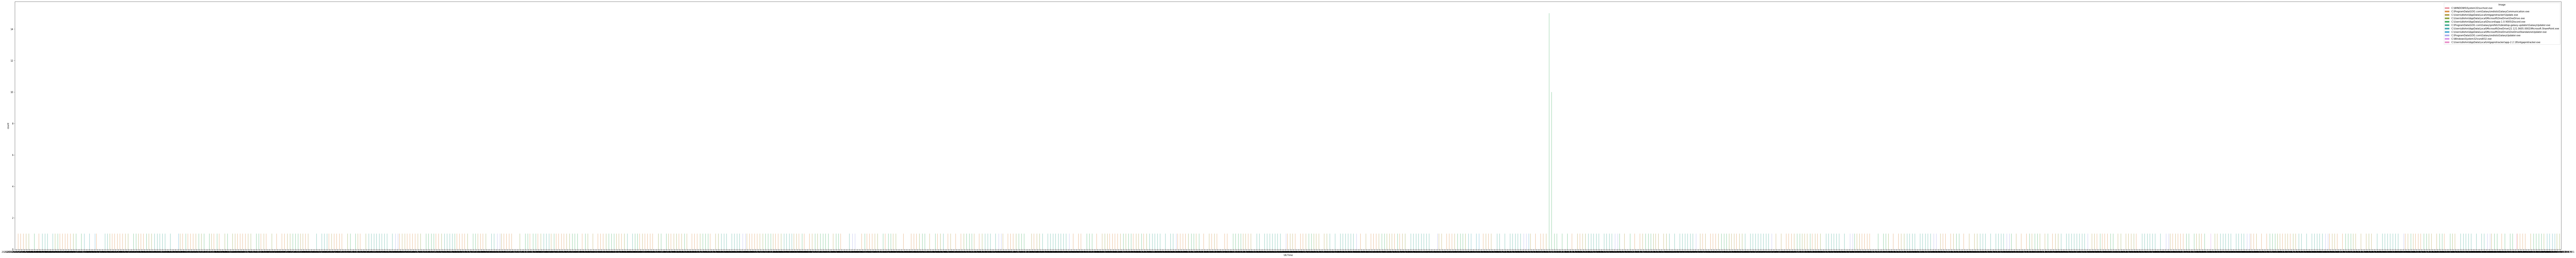

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(200,20))
sns.countplot(x='UtcTime', hue='Image', \
             data=logdf[logdf['DestinationIp'].notnull()])
plt.show()